In [1]:
import pandas as pd
import random
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
from bs4 import BeautifulSoup
from urllib.request import urlopen
import seaborn as sns
from scipy.stats import norm, chi2
import scipy.optimize as sco
import datetime

In [2]:
def get_close(tickers,
              start=datetime.date(datetime.date.today().year - 1, 
                datetime.date.today().month, 
                datetime.date.today().day)
                ,end=datetime.date.today()):
    
    data=pd.DataFrame()
    for ticker in tickers:

        try:

            yahoo_data=yf.Ticker(ticker)
            stock_price=yahoo_data.history(start=start,end=end,interval='1d').reset_index()
            stock_price['Date']=stock_price['Date'].dt.tz_localize(None)
            stock_price=stock_price.set_index('Date')
            stock_price[ticker]=stock_price['Close']+stock_price['Dividends'].shift(periods=-1)
            data=pd.concat([data,stock_price[ticker]],axis=1)

        except Exception as e:
            pass
        
    return data

In [3]:
stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]

In [4]:
tickers=stocks['Ticker'].to_list()

In [5]:
data=get_close(tickers,"2021-01-01")
data=data.dropna()
n=len(data.columns)

In [6]:
returns=np.log(1+data.pct_change())

# Portfolio Construction

In [7]:
def halton_sequences(number,base=2):
    
    #Generate Halton sequences
    
    inv_base=1/base
    
    i=number
    halton=0
    
    while i>0:
        
        digit = i%base
        halton=halton + digit*inv_base
        i=(i-digit)/base
        inv_base=inv_base/base
        
    return halton

def generate_halton(iterations,dimensions=1,base=2):
    
    #Generate a Halton Sequences at basis k , then shuffles it
    
    rng = np.random.default_rng()
    matrix=[]
    haltons=[]
    
    for i in range(iterations):
        halton=halton_sequences(i,base=base)
        haltons.append(halton)
    
    for dim in range(dimensions):
        
        matrix.append(haltons)
    
    matrix = rng.permuted(matrix, axis=1)
    return matrix

def near_psd(x, epsilon=0):
    
    #Calculate the nearest positive semi definite matrix

    if min(np.linalg.eigvals(x)) > epsilon:
        return x

    n = x.shape[0]
    var_list = np.array(np.sqrt(np.diag(x)))
    y = np.array([[x[i, j]/(var_list[i]*var_list[j]) for i in xrange(n)] for j in xrange(n)])

    eigval, eigvec = np.linalg.eig(y)
    val = np.matrix(np.maximum(eigval, epsilon))
    vec = np.matrix(eigvec)
    T = 1/(np.multiply(vec, vec) * val.T)
    T = np.matrix(np.sqrt(np.diag(np.array(T).reshape((n)) )))
    B = T * vec * np.diag(np.array(np.sqrt(val)).reshape((n)))
    near_corr = B*B.T    

    near_cov = np.array([[near_corr[i, j]*(var_list[i]*var_list[j]) for i in xrange(n)] for j in xrange(n)])
    return near_cov

def performance(perf,weights):
    
    #Calculate the performance of a portfolio on a daily basis
    
    return np.dot(perf,weights)


In [8]:
class Portfolio:
    
    #This class allows the user to calculate various metrics of a portfolio
    #and also allows to optmize the portfolio with various constraints
    
    def __init__(self,data,start_date=min(data.index),end_date=max(data.index)):
        
        self.data=data.loc[start_date:end_date]

    def portfolio(self,weights):
            
        portfolio=pd.DataFrame()
        portfolio['Portfolio']=np.sum(weights*returns,axis=1)
        
        return portfolio
    
    def evolution(self,weights):
        
        portfolio=self.portfolio(weights)
        evolution=(1+portfolio).cumprod()*100
        
        return evolution
    
    def performance(self,weights):
        performance=np.sum(self.data*weights).mean()*252
        return performance
    
    def variance(self,weights):
        variance=np.sqrt(np.dot(weights.T,np.dot(self.data.cov(),weights)))*np.sqrt(252)
        return variance
    
    def sharpe_ratio(weights):
            return self.performance(weights)/self.variance(weights)

    def optimize(self,objective='minimum_variance',constraints=False):
        
            
        def sum_equal_one(weight):
            return np.sum(weight) - 1   
        
        def sharpe_ratio(weights):
            return - self.performance(weights)/self.variance(weights)
        
        def variance(weights):
            variance=np.sqrt(np.dot(weights.T,np.dot(self.data.cov(),weights)))*np.sqrt(252)
            return variance
        
        n_assets = len(self.data.columns)
        weight = np.array([1 / n_assets] * n_assets)
        bounds = tuple((0, 1) for _ in range(n_assets))
        
        if not constraints:
            
            constraints = [{'type': 'eq', 'fun': sum_equal_one}]
        
        else:
            
            constraints=[{'type': 'eq', 'fun': sum_equal_one}]+constraints
        
        if objective=='minimum_variance':

            optimum_weights = sco.minimize(variance, weight, method='SLSQP', bounds=bounds, constraints=constraints)
        
        elif objective=='sharpe_ratio':
            
            optimum_weights = sco.minimize(sharpe_ratio, weight, method='SLSQP', bounds=bounds, constraints=constraints)
            
        else:
            
            print("Objective function undefined")
            
            
        return optimum_weights.x
    
    def black_Litterman(self,P,Q,weights,risk_aversion,tau=0.025):
        
        implied_returns=risk_aversion*self.data.cov().dot(weights).squeeze()
        omega=np.diag(np.diag(P.dot(tau*self.data.cov()).dot(P.T)))
        sigma_scaled=self.data.cov()*tau
        BL_returns= implied_returns + sigma_scaled.dot(P.T).dot(np.linalg.inv(P.dot(sigma_scaled).dot(P.T))+omega).dot(Q-P.dot(implied_returns))
        inv_cov=np.linalg.inv(self.data.cov())
        BL_weights=inv_cov.dot(BL_returns)
        BL_weights=BL_weights/BL_weights.sum()
        
        return BL_weights,BL_returns

## Risk Analysis

In [9]:
class RiskAnalysis(Portfolio):
    
    
    #This class is used to assess various risk of a portfolio such as Market Risk, VaR
    # and to know which asset could possibly contribute to it
    
    def __init__(self,returns,start_date=min(returns.index),end_date=max(returns.index)):
        
        self.returns=returns.loc[start_date:end_date]
        super().__init__(data=self.returns)
        

    def historical_var(self,weights,last_days=False,Q=5):
        
        #Return Historical VaR on the Past x days at Q confidence interval

        performance=super().portfolio(weights)
        
        if last_days:
            performance=performance[-last_days:]
            
        var=np.percentile(performance,Q)
        cvar=performance[performance<var].mean().values[0]
        
        return var,cvar
    
    
    def parametric_var(self,weights,Q=0.95):
        
        #Return parametric VaR, where assets follows a Normal Distribution
        
        intervals=np.arange(Q, 1, 0.0005, dtype=float)
        
        variance=super().variance(weights)
        VaR=variance/np.sqrt(252)*norm(loc =0 , scale = 1).ppf(1-Q)
        CVaR=variance/np.sqrt(252)*norm(loc =0 , scale = 1).ppf(1-intervals).mean()
        
        return VaR,CVaR
        
        
    def multivariate_distribution(self,
                    stress_factor=1.0,
                    iterations=10000):
        
        #Return Multivariate Distribution of a portfolio taking into account potential correlation
        
        num_asset=len(self.returns.columns)
        
        if type(stress_factor)==float:
            
            stress_vec=np.linspace(stress_factor,stress_factor,num_asset)
            
        else:       
            stress_vec=stress_factor
            
        stress_matrix=np.diag(stress_vec)
        stress_matrix=pd.DataFrame(stress_matrix,columns=self.returns.columns,index=self.returns.columns)
        
        stressed_cov=self.returns.cov().dot(stress_matrix)
        mean=self.returns.mean()
        
        multivariate=np.random.multivariate_normal(mean,stressed_cov,iterations)
        
        
        return multivariate
    
    def monte_carlo(self,spot,horizon=20/250,iterations=100000,stress_factor=1.0):
        
        
        
        num_asset=len(self.returns.columns)
        #haltons=generate_halton(iterations,num_asset,base=2)
        randoms=np.random.normal(size=(10000,num_asset)).T
        
        # Create a stress matrix to stress the covariance matrix
        
        if type(stress_factor)==float:
            
            stress_vec=np.linspace(stress_factor,stress_factor,num_asset)
            
        else: 
            
            stress_vec=stress_factor
        
        
        #Stress the volatilities of the assets
        
        vol=self.returns.std()*np.sqrt(250)*stress_vec
        
        #Create a diagonal matrix of the stress factors
        
        stress_matrix=np.diag(stress_vec)
        stress_matrix=pd.DataFrame(stress_matrix,columns=self.returns.columns,index=self.returns.columns)
        
        #Find nearest PSD matrix and apply cholesky decomposition to create correaltion effect in Monte Carlo
        
        stressed_cov=self.returns.cov().dot(stress_matrix)
        stressed_std=np.sqrt(np.diag(stressed_cov))
        corr_matrix=stressed_cov/np.outer(stressed_std,stressed_std)
        sdp_corr_matrix=near_psd(corr_matrix)
        
        cholesky=np.linalg.cholesky(corr_matrix)
            
        drift=np.exp(-0.5*horizon*vol**2)
        factors=spot*drift
        factors_vec=factors.to_numpy().reshape(num_asset,-1)
                
        simulation=np.matmul(cholesky,randoms).T
        simulation=pd.DataFrame(simulation)
        simulation.columns=self.returns.columns
 
        
        monte_carlo=factors_vec.T*np.exp(simulation.dot(np.diag(vol))*np.sqrt(horizon))
        monte_carlo=pd.DataFrame(monte_carlo)
        monte_carlo.columns=self.returns.columns
        perf_monte_carlo=np.log(monte_carlo/spot)
        
        return monte_carlo,perf_monte_carlo
    
    
    def rolling_var(self,weights,window=30,Q=1):
        
        #This function will return the rolling VaR on a x-days window following historical,parametric and multivariate model
        
        value_at_risk=pd.DataFrame()
        
        mean=returns.rolling(window).mean().dropna()
        cov=returns.rolling(window).cov().dropna()

        index=tuple(set(cov.index.get_level_values(0)))


        var={}

        for date in index:

            multivariate_var=performance(np.random.multivariate_normal(mean.loc[date],cov.loc[date],10000),weights)
            var[date]=np.percentile(multivariate_var,Q)

        multivariate_var=pd.DataFrame(var.values(),index=var.keys())
        
        portfolio=super().portfolio(weights)
        
        value_at_risk['Historical']=portfolio.rolling(window=window).apply(lambda x:np.percentile(x,Q))
        value_at_risk['Parametric']=portfolio.rolling(window=window).std()*norm(loc =0 , scale = 1).ppf(Q/100)
        value_at_risk['Multivariate']=multivariate_var
        value_at_risk['Portfolio']=portfolio
        
        return value_at_risk
    
    
    def kupiec_test(self,weights,window=30,Q=5):
        
        rolling_var=self.rolling_var(weights,window=window,Q=Q)
        rolling_var['Overshoot']=np.where(rolling_var['Portfolio']<rolling_var['Historical'],1,0)
        
        number_obs=rolling_var.shape[0]
        number_violation=np.sum(rolling_var['Overshoot'])
        number_non_violation=number_obs-number_violation
        proportion_violation=number_violation/number_obs
        proportion_non_violation=1-proportion_violation
        confidence=Q/100

        ret=super().evolution(weights)
        return_mean=(ret.iloc[-1])**(1/number_obs)-1

        kupiec=2*np.log((proportion_non_violation/(1-confidence))**(number_non_violation)
                                            *(proportion_violation/confidence)**number_violation)

        p_value=1-chi2.cdf(kupiec,1)
        
        stats={}
        stats['Kupiec Stat']=kupiec
        stats['P-value']=p_value
        stats['Proportion of failure']=proportion_violation
        
        dataframe=pd.DataFrame(stats.values(),columns=["Results"],index=stats.keys()).T
        
        return dataframe

    def pca(self,num_components=2):
        
        #Returns the eigen vectors of the covariance matrix
        
        cov_matrix=self.returns.cov()
        
        cov_matrix=returns.cov()
        
        eig_val, eig_vec=np.linalg.eig(cov_matrix)
        sorted_eig_val=eig_val.argsort()[::-1]
        eig_val=eig_val[sorted_eig_val]
        eig_vec=eig_vec[:,sorted_eig_val]
        eig_val=eig_val[:num_components]
        eig_vec=eig_vec[:,0:num_components]
        
        PC={}
        
        for i in range(eig_vec.shape[1]):
            
            PC["PC" +str(i+1)]=eig_vec[:,i]/eig_vec[:,i].sum()
        
        
        portfolio_components=pd.DataFrame(PC.values(),index=PC.keys(),columns=data.columns).T
        
        return eig_val,eig_vec,portfolio_components
                
    
    

In [10]:
test=RiskAnalysis(returns)

In [11]:
num_asset=len(data.columns)
weights=np.random.rand(num_asset)
weights=weights/weights.sum()

In [12]:
weights=test.optimize(objective="minimum_variance",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.1 - weights}])
weights=np.round(weights,2)

In [13]:
var,cvar=test.historical_var(weights)
var,cvar

(-0.011723904772350507, -0.017509664574157084)

In [14]:
var,cvar=test.parametric_var(weights)
var,cvar

(-0.012525527241366515, -0.01605426280694833)

In [15]:
perf=performance(test.multivariate_distribution(),weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.011707666877832252, -0.01514006351221989)

In [16]:
spot=data.iloc[-1]
monte_carlo=test.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1],weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.012844977385627086, -0.0161612452726543)

<AxesSubplot:>

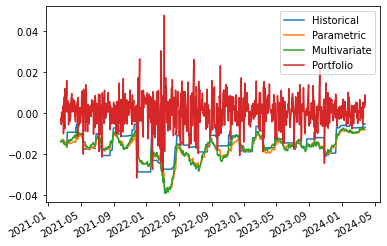

In [17]:
rolling_var=test.rolling_var(weights,window=30,Q=1).dropna()
rolling_var['Overshoot']=np.where(rolling_var['Portfolio']<rolling_var['Historical'],1,0)
rolling_var[['Historical','Parametric','Multivariate','Portfolio']].plot()

In [18]:
rolling_var.iloc[np.where(rolling_var['Overshoot']==1)]

,Historical,Parametric,Multivariate,Portfolio,Overshoot
2021-04-20,-0.009883,-0.012817,-0.010429,-0.011559,1
2021-05-11,-0.017649,-0.015086,-0.013982,-0.020137,1
2021-07-08,-0.016367,-0.013875,-0.013478,-0.018759,1
2021-07-19,-0.020758,-0.017381,-0.017587,-0.021574,1
2021-09-10,-0.009695,-0.011211,-0.010958,-0.010322,1
2021-09-28,-0.011292,-0.014314,-0.015868,-0.011688,1
2021-11-26,-0.024164,-0.017160,-0.017602,-0.031740,1
2022-01-24,-0.023202,-0.022428,-0.021339,-0.027522,1
2022-03-04,-0.028421,-0.031183,-0.033899,-0.028788,1
2022-05-09,-0.014503,-0.018869,-0.017719,-0.015871,1


In [19]:
test.kupiec_test(weights)

,Kupiec Stat,P-value,Proportion of failure
Results,3.118528,0.077407,0.064232


In [20]:
eigval,eigvec,portfolio_components=test.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.66991096, 0.14757215, 0.07276632, 0.05916326, 0.05058731])

In [21]:
portfolio_components

,PC1,PC2,PC3,PC4,PC5
ADS.DE,0.026816,-0.229557,1.243709,-0.016520,0.191610
ADYEN.AS,0.034182,-1.431339,-3.705693,-0.064799,-0.470247
AD.AS,0.005015,0.035217,-0.143699,0.086323,0.170443
AI.PA,0.013732,-0.053335,0.007435,0.088336,0.223049
AIR.PA,0.024410,0.208547,-0.260811,0.111018,0.025211
ALV.DE,0.016659,0.226735,-0.179197,0.042435,-0.025516
ABI.BR,0.015051,0.135197,0.196550,0.136695,0.078296
ASML.AS,0.027220,-0.532161,0.415023,-0.032528,0.164825
CS.PA,0.018169,0.323904,-0.338648,0.063460,-0.031391
BAS.DE,0.023317,0.223822,0.203432,-0.073216,0.036651


<AxesSubplot:>

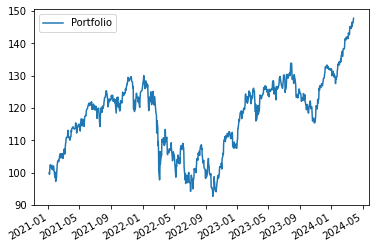

In [22]:
test.evolution(portfolio_components["PC1"]).plot()

<AxesSubplot:>

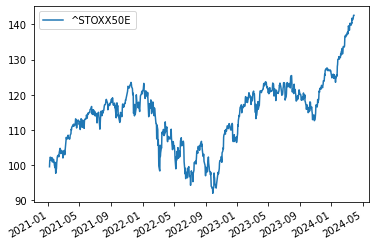

In [23]:
((1+get_close(['^STOXX50E'],"2021-01-01").pct_change()).cumprod()*100).plot()